<h1 align="center"> Computation for Physicists </h1>
<h2 align="center"> <em>Boundary Value Problems for ODE</em> </h2>
<h2 align="center" > <a href="mailto:duan@unm.edu">Dr. Duan</a> (UNM) </h2>

# Homework 13

The equation of motion for a magnetic dipole $\mathbf{m}$ in the presence of a magnetic field $\mathbf{B}$ is:
$$ \frac{\mathrm{d}\mathbf{m}}{\mathrm{d} t} = \gamma \mathbf{m}\times\mathbf{B}, $$
where the constant $\gamma$ is called the gyromagnetic ratio. Write a function or class that can compute $\mathbf{m}(t)$ at any time $t>0$ for given $\gamma$, $\mathbf{B}(t)$, and $\mathbf{m}(t=0)$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg') # make sharp images

import homework.hw13 as hw13
gamma = 1 # gyromagnetic ratio

## Larmor Precession

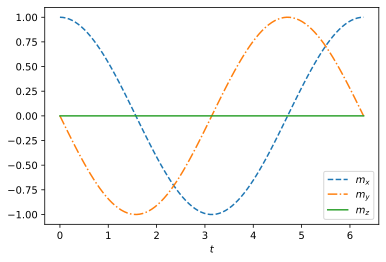

In [2]:
B = lambda t: [0, 0, 1] # constant magnetic field
m0 = [1, 0, 0] # dipole along the x-direction at t=0
dipole = hw13.MagneticDipole(gamma, B, m0)

t = np.linspace(0, 2*np.pi, 100) # time mesh
m = dipole(t) # dipole components at mesh points
plt.plot(t, m[0], '--', label='$m_x$')
plt.plot(t, m[1], '-.', label='$m_y$')
plt.plot(t, m[2], '-', label='$m_z$')
plt.xlabel('$t$')
plt.legend()
plt.show()

## Rabi Resonance

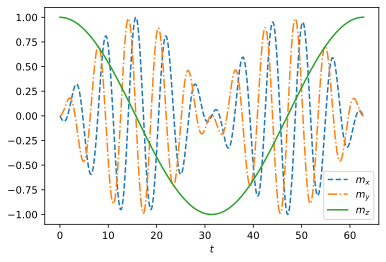

In [3]:
B = lambda t: [0.1*np.sin(t), 0.1*np.cos(t), 1] # constant Bz + rotating B⊥ 
m0 = [0, 0, 1] # initial dipole in the z direction
dipole = hw13.MagneticDipole(gamma, B, m0)

t = np.linspace(0, 20*np.pi, 500) # mesh points
m = dipole(t) # dipole components at time t
plt.plot(t, m[0], '--',label='$m_x$')
plt.plot(t, m[1], '-.', label='$m_y$')
plt.plot(t, m[2], '-', label='$m_z$')
plt.xlabel('$t$')
plt.legend()
plt.show()

# Boundary Value Problems

- An ODE by itself does not determine a unique solution. An initial value problem (IVP) uniquely determines the solution by specifying the values of the solution (and derivatives) at a single point. 

- A _boundary value problem (BVP)_ specifies the _side conditions_ at more than one point. 

- A $k$th order ODE requires $k$ side conditions.

- A two-point BVP has _boundary conditions (BC)_ specefied at the end points of the interval $[a,b]$. A BVP is linear if both the ODE and BC are linear.

- Unlike solving an IVP, the solution to an BVP must be established simultaneously on $[a, b]$. The most common methods include _shooting_, _finite difference_, _collocation_, and _Galerkin_.


# Shooting Method

- Example: To solve $y''(x)=3y^2/2$ with $y(0)=4$ and $y(1)=1$, one can try to solve $y(x)$ as an IVP with different values $s=y'(0)$ until $y(1)$ is approximately 1 [[Wikipedia]](https://en.wikipedia.org/wiki/Shooting_method).

![](https://upload.wikimedia.org/wikipedia/commons/f/f0/Shooting_method_trajectories.svg)

# Finite Difference

- The finite differencce method converts a BVP to a system of algebraic equations by replacing all the derivatives with the corresponding finite difference approximations, e.g.
\begin{align}
y'(x) &\approx \frac{y(x+h)-y(x-h)}{2h}, \\
y''(x) &\approx \frac{y(x+h)-2y(x)+y(x-h)}{h^2}.
\end{align}

- Example: Solve $y''(x)+\omega^2 y=0$ on $[0, 1]$ with specified values of $y(0)$ and $y(1)$.
    - Introduce the mesh points $x_i= i h$ ($i=0,1,\ldots, k-1$) with $h=1/(k-1)$. 
    - Approximate the ODE and BC as $y_0=y(0)$, $y_{k-1}=y(1)$, and
$$ \frac{y_{i+1}-2y_i+y_{i-1}}{h^2} + \omega^2 y_i = 0 \quad(i=1,2,\ldots,k-2),$$
where $y_i$ are the approximate values at $x_i$. 
    - Solve the algebraic equations with [`scipy.linalg.solve_banded`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve_banded.html).

In [4]:
# solve y''+w^2 y=0 on [xi, xf] with the k-point finite difference method
def oscillator(k, w, xi, xf, yi, yf):
    'Solve y''+w^2 y=0 on [xi, xf] with the k-point finite difference.'
    from scipy.linalg import solve_banded
    h = (xf-xi) / (k-1) # interval size
    # form banded linear system A y = b
    b = np.zeros(k, dtype=np.float64)
    b[0] = yi; b[-1] = yf # boundary condition
    A = np.zeros((3, k), dtype=np.float64) 
    A[1,0] = A[1,-1] = 1.0
    A[0,2:] = A[2,:-2] = 1.0/h**2
    A[1,1:-1] = w**2 - 2.0/h**2
    return solve_banded((1,1), A, b)

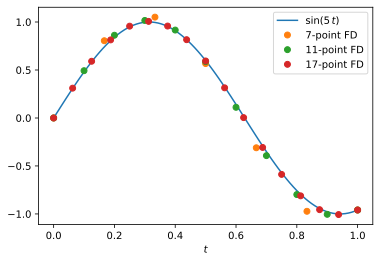

In [5]:
# problem parameters
w = 5; xi = 0; xf = 1; yi = 0; yf = np.sin(w) 
# plot the exact solution
t = np.linspace(xi, xf, 100)
plt.plot(t, np.sin(w*t), label=f'$\sin({w}\,t)$')
# plot finite-difference solutions
ks = [7, 11, 17] # number of mesh points to try
for k in ks:
    plt.plot(np.linspace(xi, xf, k), oscillator(k, w, xi, xf, yi, yf),  
             'o', label=f'{k}-point FD')
plt.xlabel('$t$')
plt.legend()
plt.show()

# Collocation Method

- The _collocation method_ approximates the solution to a BVP by the linear combination of $n$ basis functions $\phi_i(x)$:
$$ y(x) \approx v(x) = \sum_{i=0}^{n-1} \alpha_i \phi_i(x). $$
The coefficients $\alpha_i$ are determined by requiring that $v(x)$ satisfies the ODE exactly on a chosen set of _collocation points_ $a=x_0 < x_1 < \cdots < x_{n-1}=b$.

- The basis functions with global support, such as polynomials and Fourier series, gives the _spectral method_, and the basis functions with local support such as B-splines yield the _finite element method_. 

- [`scipy.integrate.solve_bvp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_bvp.html) implements the polynomial collocation method.

In [6]:
from scipy.integrate import solve_bvp
# Solve the same problem as above
# represent y''+w^2 y=0 as 1st order ODEs: u0'=u1, u1'=-w^2 u0
dudx = lambda x, u: np.array([u[1], -w**2 * u[0]])
# boundary conditions
bc = lambda ui, uf: np.array([ui[0]-yi, uf[0]-yf]) 
x0 = np.linspace(xi, xf, 10) # initial mesh
# initial guess of u 
u0 = np.empty((2,len(x0)), dtype=np.float64)
u0[0,:] = xi + (x0-xi)*(yf-yi)/(xf-xi) # linear y(x)
u0[1,:] = (yf-yi)/(xf-xi) # const. y'(x)
coll = solve_bvp(dudx, bc, x0, u0)
assert coll.success, coll.message # check the solution

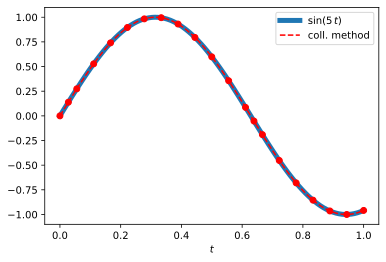

In [7]:
plt.plot(t, np.sin(w*t), lw=5, label=f'$\sin({w}\,t)$') # exact solution
plt.plot(t, coll.sol(t)[0], 'r--', label='coll. method')
plt.plot(coll.x, coll.y[0], 'ro') # final collocation points
plt.xlabel('$t$')
plt.legend()
plt.show()

# Galerkin Method

- Like the collocation method, the _Galerkin method_ also approximates the solution by the linear combination of $n$ basis functions
$$ y(x) \approx v(x) = \sum_{i=0}^{n-1} \alpha_i \phi_i(x). $$
Unlike the collocation method, however, the coefficients $\alpha_i$ are determined by requiring the remainder function $r(x)$ is orthogonal to all $n$ basis functions:
$$ \int_a^b w(x) r(x) \phi_i(x)\,\mathrm{d}x =0
\qquad(i=0,1,\ldots,n-1), $$
where $w(x)$ is the corresponding weight function if the basis functions are orthogonal polynomials.

# Eigenvalue Problem

- Consider a quantum particle of mass $m$ confined in a 1D box $[0, L]$. It has Hamiltonian
$$ \hat{H} = \frac{\hat{P}^2}{2m} = -\frac{\hbar^2}{2m}\frac{\mathrm{d}^2}{\mathrm{d} x^2}.$$

- From quantum mechanics, we know that the particle has the energy eigenfunctions 
$$\psi_n(x) \propto \sin\left(\frac{n\pi x}{L}\right)$$ 
and energy eigenvalues 
$$ E_n=\frac{1}{2m}
\left(\frac{n\pi\hbar}{L}\right)^2 
\qquad(n=1,2,\ldots). $$

- How to solve this problem numerically?

- Make the problem dimensionless by defining $z=x/L\in[0,1]$ and $E_n=(\hbar^2/2mL^2)\omega$ so that
$$ y''(z) + \omega y(z) = 0, $$
where $y(z)=\psi_n(x)$.

- Convert it to a system of linear equations by using the finite difference method with $k$ mesh points:
$$ \frac{y_{i+1} - 2y_i + y_{i-1}}{h^2} = -\omega y_i
\qquad(i=1,2,\ldots,k-2). $$
where $y_i=y(i h)$ with $h=1/(k-1)$. The boundary conditions are $y_0=y_{k-1}=0$. 

- Solve the eigenvalue $\omega$ from the following tridiagonal linear system using [`scipy.linalg.eigh_tridiagonal`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.eigh_tridiagonal.html):
$$ \frac{1}{h^2}\begin{bmatrix}
2 & -1 & 0 & \cdots & 0 \\
-1 & 2 & -1 & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & \cdots & 2
\end{bmatrix} \begin{bmatrix}
y_1 \\ y_2 \\ \vdots \\ y_{k-2}
\end{bmatrix}
= \omega\begin{bmatrix}
y_1 \\ y_2 \\ \vdots \\ y_{k-2}
\end{bmatrix}. $$


In [8]:
class ParticleInBox:
    def __init__(self, k):
        '''Solve the energy eigenvalues and eigenfunctions of a quantum article
        on k mesh points.
        '''
        assert k>3, "There should be at least 4 mesh points."
        from scipy.linalg import eigh_tridiagonal
        h = 1 / (k-1) # step size
        H_diag = 2/h**2*np.ones(k-2) # diagonal elements
        H_off = -1/h**2*np.ones(k-3) # off-diag. elements
        self.w, v = eigh_tridiagonal(H_diag, H_off)
        zeros = np.zeros((k-2,1))
        self.psi = np.concatenate((zeros, v.T, zeros), axis=1) # add the endpoints

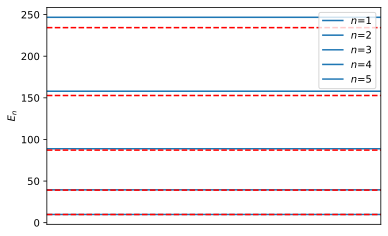

In [9]:
k = 21 # number of mesh points
particle = ParticleInBox(k)
# plot the first 5 energy levels
for n in range(1, 6):
    plt.axhline((n*np.pi)**2, label=f'$n$={n}')
    plt.axhline(particle.w[n-1], c='r', ls='--')
plt.ylabel('$E_n$')
plt.gca().xaxis.set_major_locator(plt.NullLocator()) # no x ticks
plt.legend()
plt.show()

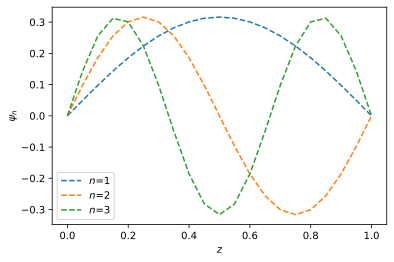

In [10]:
x = np.linspace(0, 1, k)
# plot first 3 energy eigenfunctions
for n in range(1, 4):
    plt.plot(x, particle.psi[n-1], '--', label=f'$n$={n}')
plt.ylabel('$\psi_n$')
plt.xlabel('$z$')
plt.legend()
plt.show()

# Homework 14

Use [`scipy.integrate.solve_bvp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_bvp.html) to find two distinct solutions to $y''(x)=3y^2/2$ with $y(0)=4$ and $y(1)=1$.